In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pathlib

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.4
numpy version: 1.19.5
seaborn version: 0.11.2
GPU present


2022-04-13 13:18:52.774291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:52.779056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:52.779168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# paths to load datasets from
val_store_path = '../datasets/sa/validation'

# convert to pathlib Path objects
val_dir = pathlib.Path(val_store_path)

# get list of datasets in dir
val_ds_paths = sorted(list(val_dir.glob('*.csv')))

# extract classification target from file names
val_ds_type = np.array([x.parts[-1].split('_')[:2] for x in val_ds_paths])
val_ds_order = [s.upper() for s in val_ds_type[:,0]]
val_ds_loc = [s.upper() for s in val_ds_type[:, 1]]

# generate signal type tags
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in val_ds_order])))}

In [3]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for dataset_paths in [val_ds_paths]:
    # temp lists for appending
    temp_specs = []
    temp_datasets = []

    for path in dataset_paths:
        print(f'loading {path}...', end=' ')

        # load dataset details
        df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
        df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

        temp_specs.append(df_spec)

        # load data, strip unnecessary bits out
        df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
        df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
        df['I'] = df['I'].astype('float')

        print(f'loaded')

        temp_datasets.append(df)

    # append loaded datasets of each type to dataset lists
    specs.append(temp_specs)
    datasets.append(temp_datasets)

    # delete temp variables
    del temp_specs, temp_datasets, df, df_spec
    
print('done.')

loading ../datasets/sa/validation/bnet_office_val.csv... loaded
loading ../datasets/sa/validation/bnet_roof_val.csv... loaded
loading ../datasets/sa/validation/bt_library_val.csv... loaded
loading ../datasets/sa/validation/bt_office_val.csv... loaded
loading ../datasets/sa/validation/bt_room_val.csv... loaded
loading ../datasets/sa/validation/fm_roof_val.csv... loaded
loading ../datasets/sa/validation/fnet_library_val.csv... loaded
loading ../datasets/sa/validation/fnet_office_val.csv... loaded
loading ../datasets/sa/validation/fnet_room_val.csv... loaded
loading ../datasets/sa/validation/lte_library_val.csv... loaded
loading ../datasets/sa/validation/lte_office_val.csv... loaded
loading ../datasets/sa/validation/lte_room_val.csv... loaded
loading ../datasets/sa/validation/wifi_library_val.csv... loaded
loading ../datasets/sa/validation/wifi_office_val.csv... loaded
loading ../datasets/sa/validation/wifi_room_val.csv... loaded
done.


In [4]:
# split dataset(s) into records, extract test dataset
processed = []

# expected length of each record
rlength = 1024
    
print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
for i, zipped in enumerate(list(zip(datasets, specs, [val_ds_order], [val_ds_loc]))):
    for dataset, spec, ds_order, ds_loc in zip(*zipped):
        nrecords = 400
        nsamples = spec.loc['NumberSamples']['info']
        ds_length = dataset.shape[0]

        # sanity check
        print(f'{ds_order:<13}\t{ds_loc:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

        # loop through dataset to split 
        for j in range(nrecords):
            # extract sample length worth of samples for each record, then transpose for easier access later
            record = dataset.iloc[(nsamples * j):(nsamples * (j+1))].values.T

            # pad shorter records with random padding to rlength
            if nsamples < rlength:
                # deterine pad amount
                pad_length = rlength - nsamples
                lpad_length = np.random.randint(0, pad_length+1)
                rpad_length = pad_length - lpad_length

                # generate pad
                lpad = np.zeros((2, lpad_length))
                rpad = np.zeros((2, rpad_length))

                # concatenate pad
                record = np.concatenate([lpad, record, rpad], axis=1)

            # truncate longer records to rlength
            elif nsamples > rlength:
                record = record[:,:rlength]

            # add processed record to list
            processed.append([ds_order, signal_tags[ds_order], ds_loc, record, bool(i)])

# convert list into dataframes for later use, randomise, extract test records
df_test = pd.DataFrame(processed, columns=['signal_type', 'tag', 'location', 'record' ,'noisy']).sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Test\t{df_test.shape[0]:<5}\t{df_test["record"].iloc[0].shape[1]}')


Type		Location	Total Records	Samples/Record
BNET         	OFFICE         	400    		1024   
BNET         	ROOF           	400    		1024   
BT           	LIBRARY        	400    		1024   
BT           	OFFICE         	400    		1024   
BT           	ROOM           	400    		1024   
FM           	ROOF           	400    		1280   
FNET         	LIBRARY        	400    		1024   
FNET         	OFFICE         	400    		1024   
FNET         	ROOM           	400    		1024   
LTE          	LIBRARY        	400    		1024   
LTE          	OFFICE         	400    		1024   
LTE          	ROOM           	400    		1024   
WIFI         	LIBRARY        	400    		1024   
WIFI         	OFFICE         	400    		1024   
WIFI         	ROOM           	400    		1024   

            Stats             
Dataset	Length	Records/Sample
Test	6000 	1024


In [7]:
# load models from directory
# define custom loss used to train
def custom_loss(y_actual, y_pred):
    difference = tf.math.abs(tf.math.subtract(y_actual, y_pred))
    loss = tf.math.reduce_mean(difference)

    return loss

# path to models
model_paths = '../saved_models/AANN'

models = []

# convert path to pathlib object
models_dir = pathlib.Path(model_paths)

for path in models_dir.iterdir():
    if path.is_dir():
        print(f'loading {path}...', end=' ')

        # load models
        models.append(tf.keras.models.load_model(path, custom_objects={'custom_loss' : custom_loss}))

        print('done.')

loading ../saved_models/AANN/LTE... done.
loading ../saved_models/AANN/BT... done.
loading ../saved_models/AANN/WIFI... done.
loading ../saved_models/AANN/BNET... done.
loading ../saved_models/AANN/NOISE... done.
loading ../saved_models/AANN/FM... done.
loading ../saved_models/AANN/FNET... done.


In [12]:
# do model evaluation
# declare dict to store pred results
results = {
    model.name : {
        pred_signal : [] 
        for pred_signal in signal_tags.keys()
    } 
    for model in models
}

# initiate mean-squared-loss function for score calculation
loss = custom_loss

# iterate through every signal type for each model
print(f'Model\t\tSignal\tShape')
for signal in signal_tags.keys():
    record_subset = df_test[df_test['signal_type'] == signal]

    # process subset for prediction    
    pred_input = np.concatenate(record_subset['record'].values).reshape(
    (record_subset.shape[0], 2, rlength, 1))
    
    for model in models:
        model_name = model.name

        # predict
        pred_output = model.predict(pred_input)

        # generate loss scores
        results[model_name][signal] = np.array([loss(truth, predicted).numpy() for truth, predicted in zip(pred_input, pred_output)])
        print(f'{model_name: <15} {signal: <7} {str(results[model_name][signal].shape):<7} ')

Model		Signal	Shape
AANN_LTE        BNET    (800,)  
AANN_BT         BNET    (800,)  
AANN_WIFI       BNET    (800,)  
AANN_BNET       BNET    (800,)  
AANN_NOISE      BNET    (800,)  
AANN_FM         BNET    (800,)  
AANN_FNET       BNET    (800,)  
AANN_LTE        BT      (1200,) 
AANN_BT         BT      (1200,) 
AANN_WIFI       BT      (1200,) 
AANN_BNET       BT      (1200,) 
AANN_NOISE      BT      (1200,) 
AANN_FM         BT      (1200,) 
AANN_FNET       BT      (1200,) 
AANN_LTE        FM      (400,)  
AANN_BT         FM      (400,)  
AANN_WIFI       FM      (400,)  
AANN_BNET       FM      (400,)  
AANN_NOISE      FM      (400,)  
AANN_FM         FM      (400,)  
AANN_FNET       FM      (400,)  
AANN_LTE        FNET    (1200,) 
AANN_BT         FNET    (1200,) 
AANN_WIFI       FNET    (1200,) 
AANN_BNET       FNET    (1200,) 
AANN_NOISE      FNET    (1200,) 
AANN_FM         FNET    (1200,) 
AANN_FNET       FNET    (1200,) 
AANN_LTE        LTE     (1200,) 
AANN_BT         LTE    

In [ ]:
# np.save('AANN_results.npy', results)

In [13]:
# construct table of information
print('Model\t\tSignal\tMean\t\tMedian\t\tMax\t\tMin')

for model_name, model_results in results.items():
    print('-'*80)
    output_string = f'{model_name :<15} '
    for signal, result in model_results.items():
        # calculate metrics
        mean = np.mean(result)
        median = np.median(result)
        maximum = np.max(result)
        minimum = np.min(result)

        # construct string
        output_string += f'{signal :<7} {mean :<15.7f} {median :<15.7f} {maximum :<15.7f} {minimum :<15.7f}'

        # print and reset string
        print(output_string)

        output_string = f'\t\t'

Model		Signal	Mean		Median		Max		Min
--------------------------------------------------------------------------------
AANN_LTE        BNET    0.0003142       0.0002901       0.0068465       0.0002469      
		BT      0.0007861       0.0002218       0.0163208       0.0001633      
		FM      0.0002823       0.0002769       0.0003696       0.0002374      
		FNET    0.0006608       0.0005444       0.0013373       0.0001192      
		LTE     0.0005746       0.0006132       0.0074828       0.0001640      
		WIFI    0.0005030       0.0003093       0.0044051       0.0001411      
--------------------------------------------------------------------------------
AANN_BT         BNET    0.0003195       0.0003076       0.0033291       0.0002785      
		BT      0.0003792       0.0002449       0.0125878       0.0002058      
		FM      0.0002747       0.0002743       0.0003254       0.0002381      
		FNET    0.0007757       0.0007793       0.0013717       0.0001022      
		LTE     0.0015814       0.00188

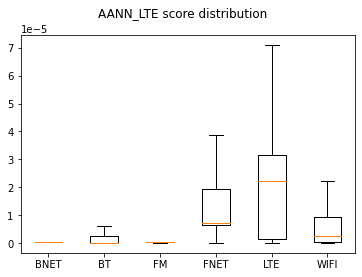

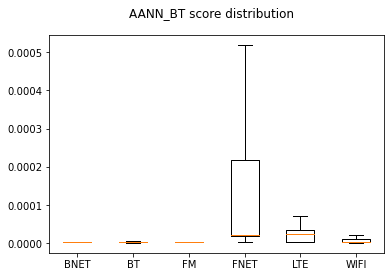

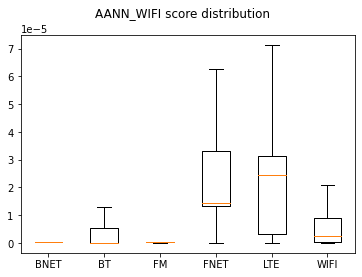

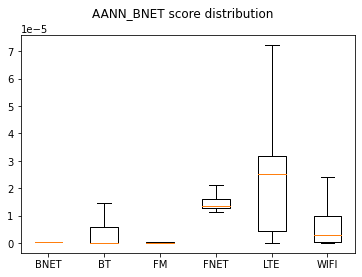

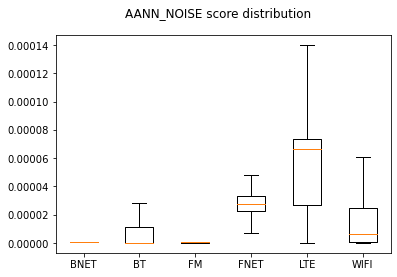

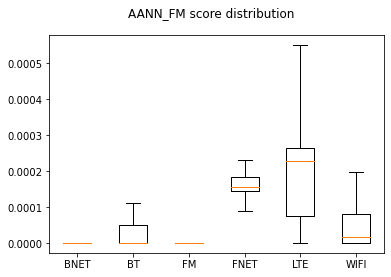

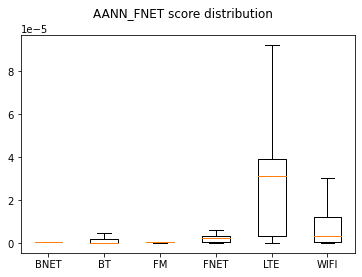

In [102]:
# create boxplots of data
for model_name, model_results in results.items():
    fig, ax = plt.subplots(1, 1)
    fig.suptitle(f'{model_name} score distribution')

    ax.boxplot(model_results.values(), labels=model_results.keys(), sym='')
    # ax.set_ylim(-0.01, 0.5)

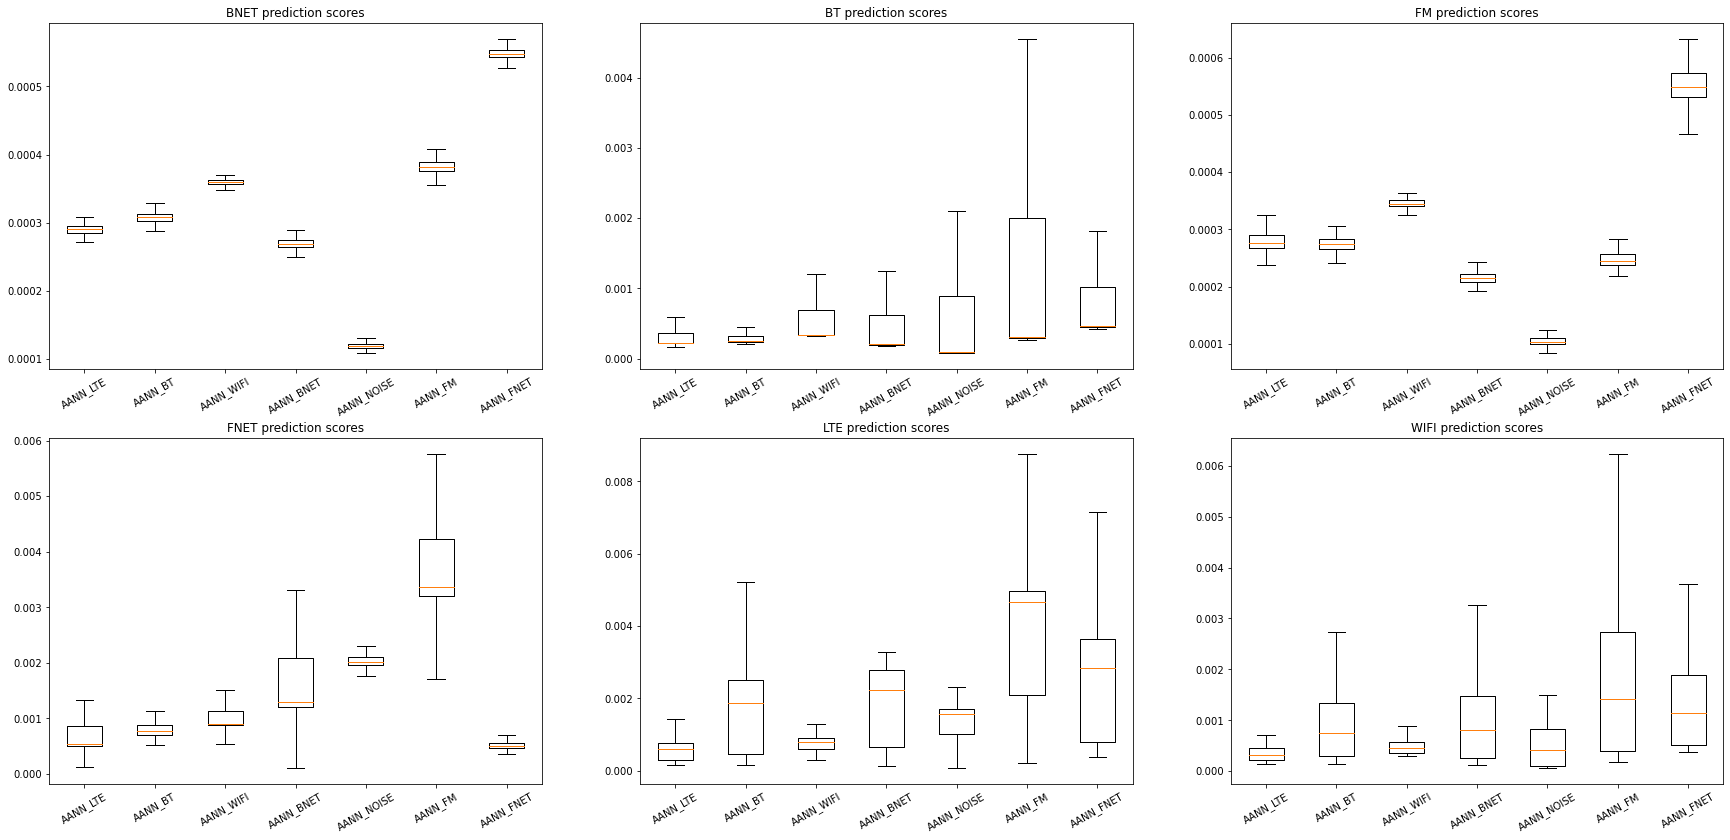

In [16]:
# more boxplots
results_invert = {signal_name : {model_name : results[model_name][signal_name] for model_name in results.keys()} for signal_name in results['AANN_BT'].keys()}

fig = plt.figure(figsize=(30, 14))
for i, (signal_name, signal_results) in enumerate(results_invert.items()):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_title(f'{signal_name} prediction scores')

    ax.boxplot(signal_results.values(), labels=signal_results.keys(), sym='')
    ax.set_xticklabels(signal_results.keys(), rotation=30)